# Indexes

<hr>

Indexes support the efficient execution of queries in MongoDB. Without indexes, MongoDB must perform a <span style="color:red">collection scan</span>, i.e. scan every document in a collection, to select those documents that match the query statement.

==> With an appropriate index exists for a query, MongoDB can use the index to limit the number of documents it must inspect.

<br>

Indexes are special data structures <span style="color:red">(MongoDB indexes use a B-tree data structure.) </span> that store a small portion of the collection’s data set in an easy to traverse form. 

**Properties:**
1. The index stores the value of a specific field or set of fields, ordered by the value of the field. 
2. The ordering of the index entries supports efficient equality matches and range-based query operations. 
3. MongoDB can return sorted results by using the ordering in the index.

**Diagram illustrates a query that selects and orders the matching documents using an index:**

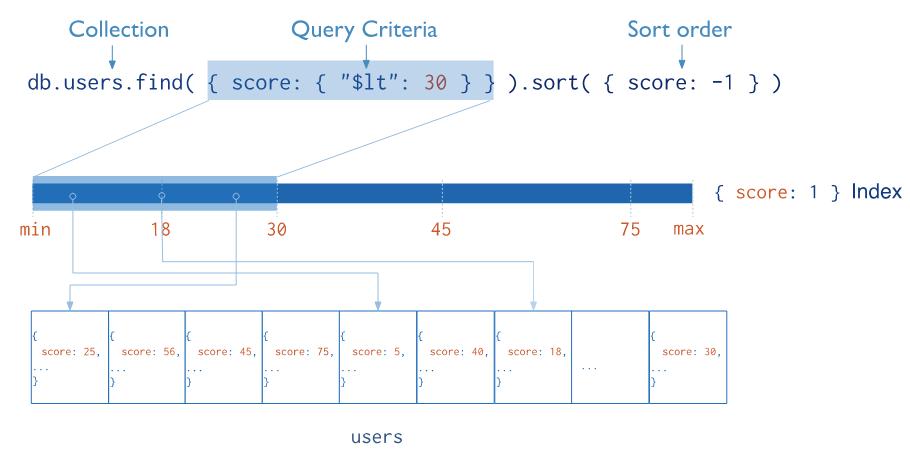

<br>

**MongoDB defines indexes at the <span style="color:red">collection</span> level and supports indexes on any field or sub-field of the documents**

### Default _id Index

1. Unique index
2. Cannot drop this index

**<span style="color:orange">NOTE:</span>** <br>
In <span style="color:red">sharded clusters</span>, if we do not use the _id field as the <span style="color:red">shard key</span>, then our application must ensure the uniqueness of the values in the _id field to prevent errors. This is most-often done by using a standard auto-generated <span style="color:red">ObjectId</span>.

### Create Index

To create an index in the **Mongo Shell**, use <span style="color:green">db.collection.createIndex()</span>

``` mongo-shell

db.collection.createIndex( <key and index type specification>, <options> )

```

**Example:** Create index on the **name** field: 
``` mongo-shell

db.collection.createIndex( { name: -1 } )

```

#### Index names

The default name for an index is the concatenation of the indexed keys and each key’s direction in the index ( i.e. 1 or -1) using underscores as a separator.
<br>

Example: <br>
{ item : 1, quantity: -1 } has the name item_1_quantity_-1

**We can create indexes with a custom name**
Example: creates an index on **item** and **quantity** named **query for inventory**:

```mongo-shell

db.products.createIndex(
  { item: 1, quantity: -1 } ,
  { name: "query for inventory" }
)

```

We can view index names using the <span style="color:green">db.collection.getIndexes() </span> method.

**Note:**

1. Cannot rename an index once created
2. Must drop and re-create the index with a new name

### Index Types

MongoDB provides a number of different index types to support specific types of data and queries.

#### Single Field

MongoDB supports the creation of user-defined ascending/descending indexes on a [single field of a document]().
<br>
For a single-field index and sort operations, the sort order (i.e. ascending or descending) of the index key does not matter because MongoDB can traverse the index in either direction.<br>

==> See [Single Field Indexes]() and [Sort with a Single Field Index]() for more information on single-field indexes.

#### Compound Index

MongoDB also supports user-defined indexes on multiple fields, i.e. [compound indexes]().
<br>
**The order of fields listed in a compound index has significance.**
<br>
Example:<br>
if a compound index consists of **{ userid: 1, score: -1 }**, the index sorts first by **userid** and then, within each **userid** value, sorts by **score**.
<br>
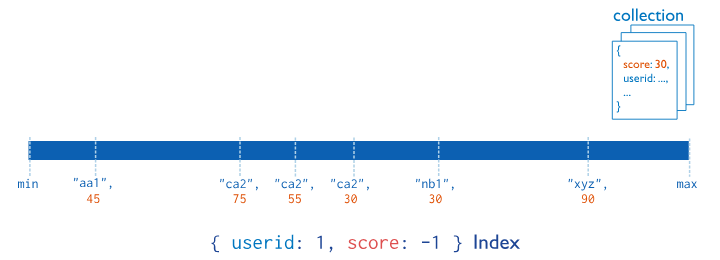
<br>


#### Multikey Index

MongoDB uses [multikey indexes]() to index the content stored in arrays. <br>

If we index a field that holds an array value, MongoDB creates separate index entries for every element of the array. <br>
These multikey indexes allow queries to select documents that contain arrays by matching on element or elements of the arrays.

#### Geospatial Index


To support efficient queries of geospatial coordinate data, MongoDB provides two special indexes:  <br>

1. [2d indexes]() that uses planar geometry when returning results 
2. [2dsphere indexes]() that use spherical geometry to return results.


#### Text Indexes

MongoDB provides a **text index** type that supports searching for string content in a collection.

**Properties:**
1. These text indexes do not store language-specific stop words (e.g. “the”, “a”, “or”)
2. stem the words in a collection to only store root words.

#### Hashed Indexes

To support [hash based sharding](), MongoDB provides a [hashed index]() type, which indexes the hash of the value of a field. <br>

These indexes have a more random distribution of values along their range, but only support equality matches and cannot support range-based queries.

### Index Properties


#### Unique Indexes

The [unique]() property for an index causes MongoDB to reject duplicate values for the indexed field. Other than the unique constraint, **unique indexes are functionally interchangeable with other MongoDB indexes**.

#### Partial Indexes

[Partial indexes]() only index the documents in a collection that meet a specified filter expression. <br>

By indexing a **subset of the documents in a collection**, partial indexes have lower storage requirements and reduced performance costs for index creation and maintenance.<br>

Partial indexes offer a superset of the functionality of sparse indexes and should be preferred over sparse indexes.


#### Sparse Indexes

The [sparse]() property of an index ensures that the index only contain entries for documents that have the indexed field. The index **skips documents that do not have the indexed field**. <br>


#### TTL Indexes

[TTL indexes]() are special indexes that MongoDB can use to automatically remove documents from a collection after a certain amount of time. <br>

This is ideal for certain types of information like machine generated event data, logs, and session information that only need to persist in a database for a finite amount of time.

### Index Use

Indexes can improve the efficiency of read operations. <br>

The [Analyze Query Performance](https://docs.mongodb.com/manual/tutorial/analyze-query-plan/) tutorial provides an example of the execution statistics of a query with and without an index. <br>

For information on how MongoDB chooses an index to use, [see query optimizer](https://docs.mongodb.com/manual/core/query-plans/#read-operations-query-optimization).

### Indexes and Collation

[Collation](https://docs.mongodb.com/manual/reference/collation/) allows users to specify language-specific rules for string comparison, such as rules for lettercase and accent marks. <br>

**To use an index for string comparisons, an operation must also specify the same collation**. That is, an index with a collation cannot support an operation that performs string comparisons on the indexed fields if the operation specifies a different collation.

**Example:** an index on a string field category with the collation locale "fr".

```mongo-shell

db.myColl.createIndex( { category: 1 }, { collation: { locale: "fr" } } )

```

query operation, which specifies the same collation as the index, can use the index:

```mongo-shell

db.myColl.find( { category: "cafe" } ).collation( { locale: "fr" } )

```

However, query operation, which by default uses the “simple” binary collator, cannot use the index:

```mongo-shell

db.myColl.find( { category: "cafe" } )

```

**<span style="color:red">For a compound index where the index prefix keys are not strings, arrays, and embedded documents, an operation that specifies a different collation can still use the index to support comparisons on the index prefix keys.</span>**

**Example:** a compound index on the numeric fields score and price and the string field category; the index is created with the collation locale "fr" for string comparisons: 

```mongo-shell

db.myColl.createIndex(
   { score: 1, price: 1, category: 1 },
   { collation: { locale: "fr" } } )

```

operations, which use **"simple"** binary collation for string comparisons, can use the index:

```mongo-shell

db.myColl.find( { score: 5 } ).sort( { price: 1 } )
db.myColl.find( { score: 5, price: { $gt: NumberDecimal( "10" ) } } ).sort( { price: 1 } )

```

operation, which uses "simple" binary collation for string comparisons on the indexed category field, can use the index to fulfill only the score: 5 portion of the query:

```mongo-shell

db.myColl.find( { score: 5, category: "cafe" } )

```

<span style="color:red">For more information on collation, see the [collation reference page](https://docs.mongodb.com/manual/reference/collation/).</span>


**The following indexes only support simple binary comparison and do not support [collation](https://docs.mongodb.com/manual/reference/bson-type-comparison-order/#collation):**

1. [text](https://docs.mongodb.com/manual/core/index-text/) indexes
2. [2d](https://docs.mongodb.com/manual/core/2d/) indexes
3. [geoHaystack](https://docs.mongodb.com/manual/core/geohaystack/) indexes


### Covered Queries

When the query criteria and the [projection](https://docs.mongodb.com/manual/reference/glossary/#term-projection) of a query **include only the indexed fields**, MongoDB returns results directly from the index without scanning any documents or bringing documents into memory. These covered queries can be very efficient.

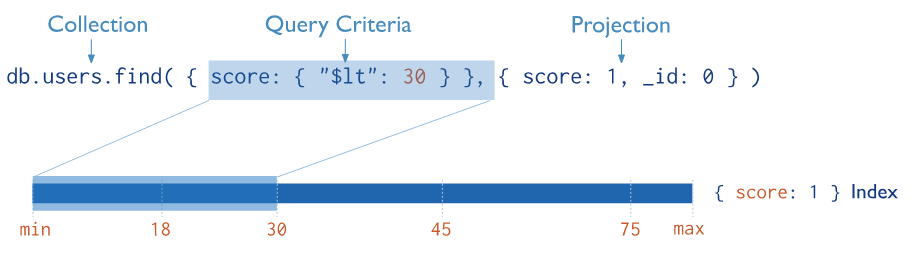

see [Covered Query](https://docs.mongodb.com/manual/core/query-optimization/#read-operations-covered-query).

### Index Intersection

MongoDB can use the [intersection of indexes](https://docs.mongodb.com/manual/core/index-intersection/) to fulfill queries. <br>

For queries that specify compound query conditions, if one index can fulfill a part of a query condition, and another index can fulfill another part of the query condition, then MongoDB can use the intersection of the two indexes to fulfill the query. <br>

Whether the **use of a compound index or the use of an index intersection is more efficient** depends on the particular query and the system. <br>

see [Index Intersection](https://docs.mongodb.com/manual/core/index-intersection/).

### Restrictions

Certain restrictions apply to indexes, such as the length of the index keys or the number of indexes per collection.  <br>

See [Index Limitations](https://docs.mongodb.com/manual/reference/limits/#index-limitations)

### Additional Considerations

Although indexes can improve query performances, indexes also present some operational considerations. See [Operational Considerations for Indexes](https://docs.mongodb.com/manual/core/data-model-operations/#data-model-indexes) for more information. <br>

Applications may encounter reduced performance during index builds, including limited read/write access to the collection. For more information on the index build process, see [Index Builds on Populated Collections](https://docs.mongodb.com/manual/core/index-creation/#index-operations), including the [Index Builds in Replicated Environments](https://docs.mongodb.com/manual/core/index-creation/#index-operations-replicated-build) section.


## Single Field Indexes

All collections have an index on the [_id field](https://docs.mongodb.com/manual/indexes/#index-type-id), and applications and users may add additional indexes to support important queries and operations.

### Create an Ascending Index on a Single Field

Example:

```mongo-shell

db.records.createIndex( { score: 1 } )

```

The value of the field in the index specification describes the kind of index for that field. <br>
For example, a value of __1__ specifies an index that orders items in **ascending order**. A value of **-1** specifies an index that orders items in **descending order**. <br>

For additional index types, see [index types](https://docs.mongodb.com/manual/indexes/#index-types).

### Create an Index On an Embedded Field


We can create indexes on fields within embedded documents, just as you can index top-level fields in documents. <br>
Indexes on embedded fields allow you to use a “dot notation,” to introspect into embedded documents. <br>

**Example:**
<br>
a collection named **records** that holds documents that resemble the following sample document:

```mongo-shell

{
  "_id": ObjectId("570c04a4ad233577f97dc459"),
  "score": 1034,
  "location": { state: "NY", city: "New York" }
}

```

creates an index on the location.state field:

```mongo-shell

db.records.createIndex( { "location.state": 1 } )

```


### Create an Index on Embedded Documment

We can also create indexes on embedded document as a whole.

**Example:** in above example, **location** field is an embedded document, containing the embedded fields **city** and **state**, creates an index on the location field as a whole:

```mongo-shell

db.records.createIndex( { location: 1 } )

```

query can use the index on the location field:

```mongo-shell

db.records.find( { location: { city: "New York", state: "NY" } } )

```

**<span style="color:orange">NOTE:</span>**
<br>
Although the query can use the index, the result set does not include the sample document above. When performing equality matches on embedded documents, <span style="color:red"> field order matters and the embedded documents must match exactly </span>. See [Query Embedded Documents](https://docs.mongodb.com/manual/reference/method/db.collection.find/#query-embedded-documents) for more information regarding querying on embedded documents.

## Multikey Indexes

<hr>

To index a field that holds an array value, MongoDB creates an index key for each element in the array. **Multikey indexes** can be constructed over arrays that hold both <span style="color:red"> scalar values </span> (e.g. strings, numbers) and <span style="color:red"> nested documents </span>.

### Create Multikey Index

To create a **multikey index**, use the <span style="color:green">db.collection.createIndex() </span> method:

```mongo-shell

    db.coll.createIndex( { <field>: < 1 or -1 > } )
    
```

#### Index Bounds

If an index is multikey, then computation of the index bounds follows special rules. For details on [multikey index bounds](#Multikey-Index-Bounds)

#### Unique Multikey Index

For <span style="color:red">unique </span> indexes, the unique constraint applies across <span style="color:red">separate documents </span> in the collection rather than within a single document.